In [ ]:
# Install required libraries
!pip install lime shap scikit-learn numpy pandas matplotlib tensorflow pillow

# Note: After installation, restart the runtime to ensure all libraries are properly loaded.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cfe7e50d1449931f9ec89bf41b53643f6ffec6003651217d0315e2b9f7cdf3fb
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fernando2rad/x-ray-lung-diseases-images-9-classes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/x-ray-lung-diseases-images-9-classes


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def preprocess_images(source_folder, target_folder, img_size=(256, 256)):
    categories = os.listdir(source_folder)
    for category in categories:
        img_paths = os.listdir(os.path.join(source_folder, category))
        os.makedirs(os.path.join(target_folder, category), exist_ok=True)
        for img_name in tqdm(img_paths, desc=f"Processing {category}"):
            img_path = os.path.join(source_folder, category, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            img_resized = cv2.resize(img, img_size)  # Resize image
            cv2.imwrite(os.path.join(target_folder, category, img_name), img_resized)  # Save preprocessed image

# Usage
source_dir = '/kaggle/input/x-ray-lung-diseases-images-9-classes'
target_dir = '/kaggle/processed/x-ray-lung-diseases-images'
preprocess_images(source_dir, target_dir)


Processing 04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia): 100%|██████████| 644/644 [00:05<00:00, 115.95it/s]
Processing 02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema): 100%|██████████| 678/678 [00:05<00:00, 126.09it/s]
Processing 03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio): 100%|██████████| 629/629 [00:04<00:00, 130.63it/s]
Processing 08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias): 100%|██████████| 544/544 [00:03<00:00, 168.87it/s]
Processing 06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases): 100%|██████████| 658/658 [00:04<00:00, 156.06it/s]
Processing 05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose): 100%|██████████| 594/594 [00:03<00:00, 169.45it/s]
Processing 00 Anatomia Normal: 100%|██████████| 1340/1340 [00:08<00:00, 159.01it/s]
Processing 07 Alterações de Mediastino (Pericardite, Malfo

## **Exploratory Data Analysis (EDA)**

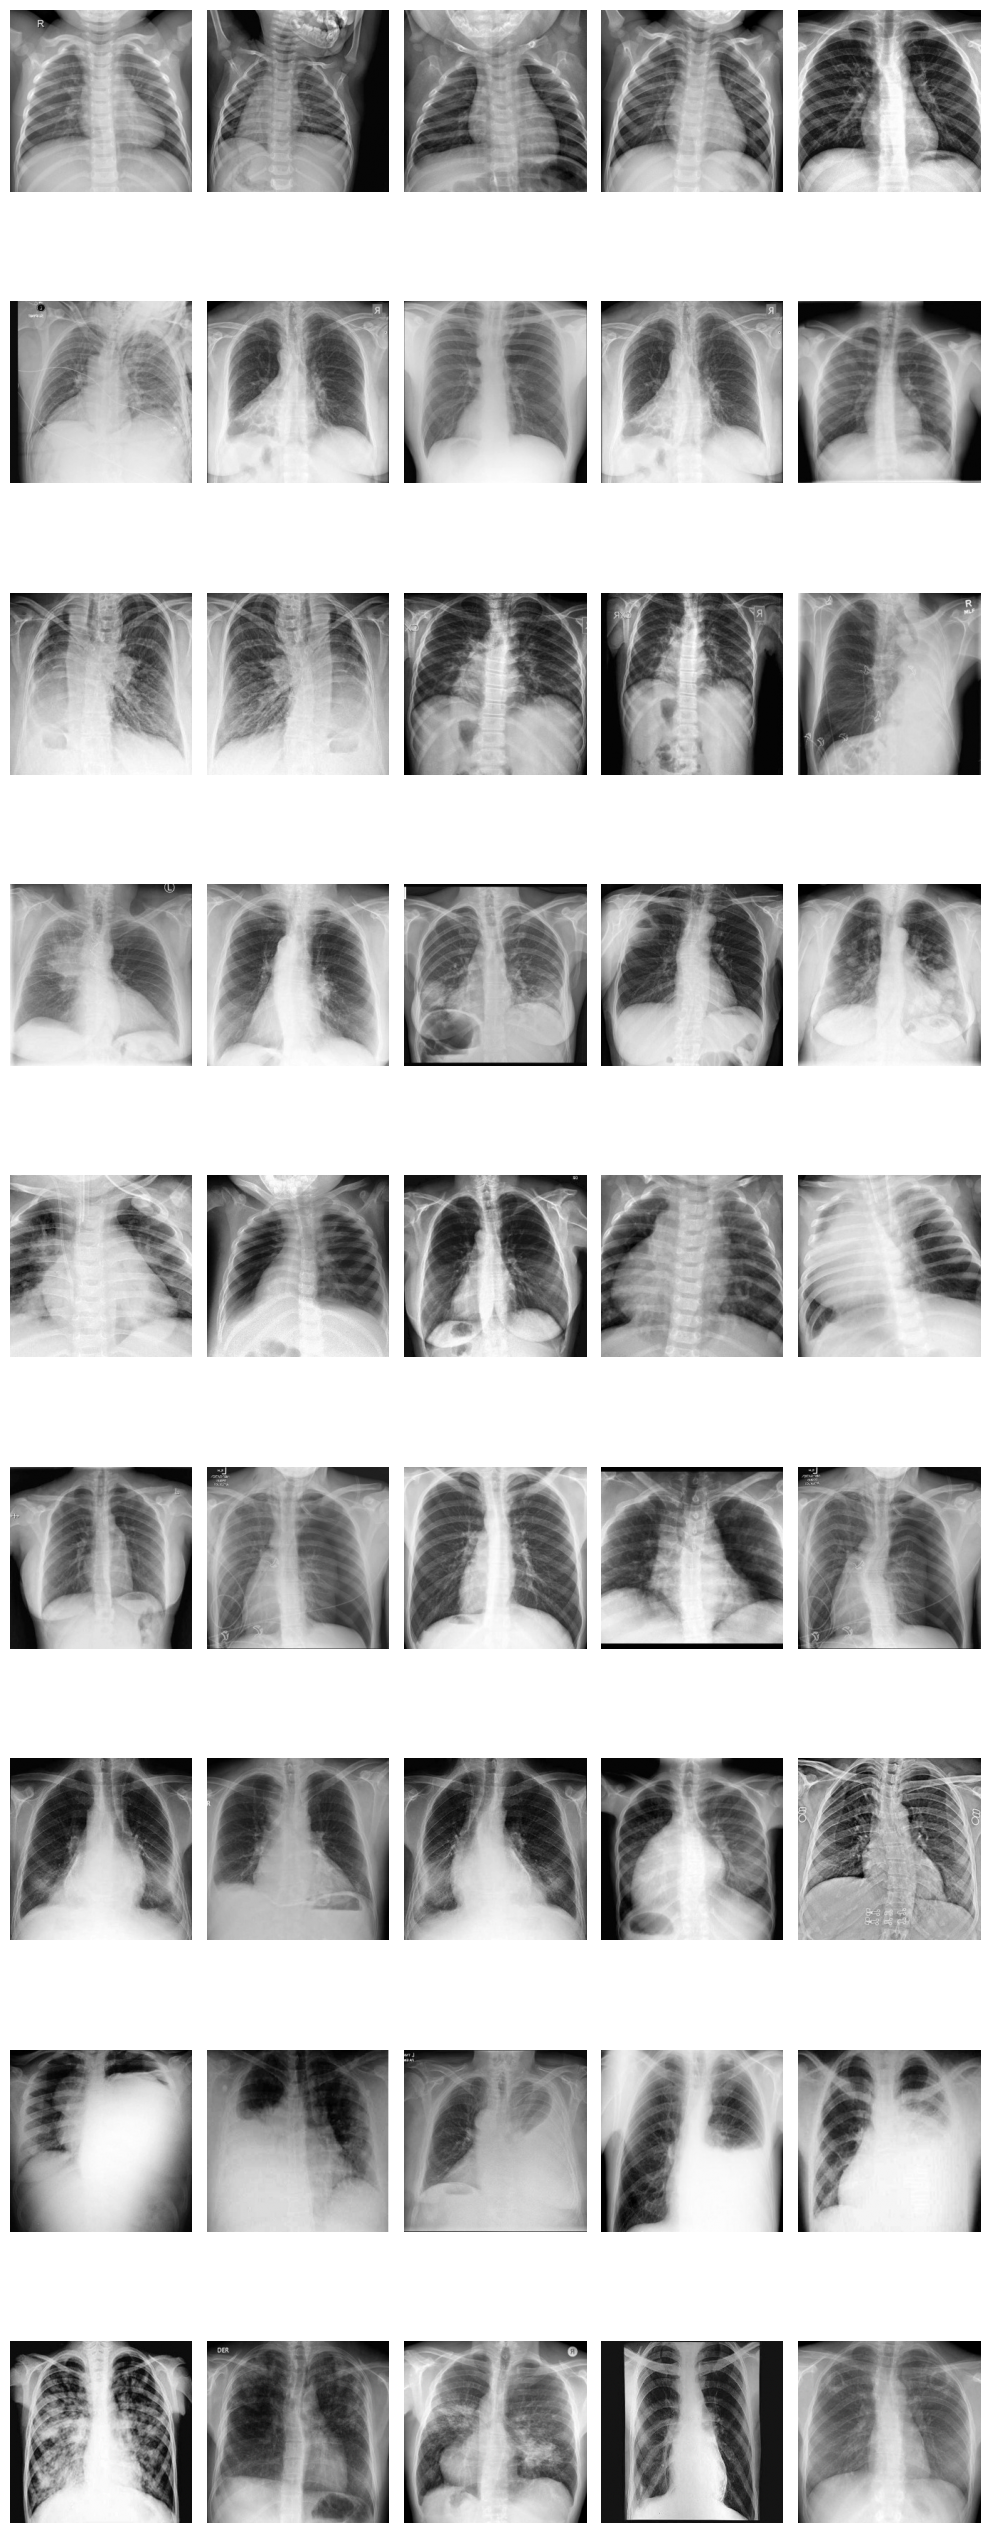

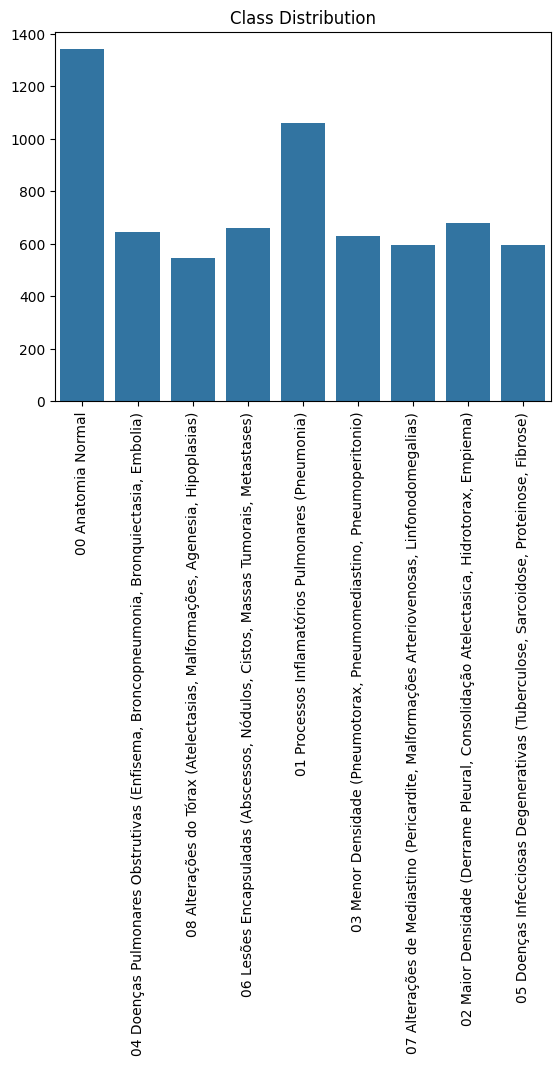

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sample_images(data_folder, num_samples=5):
    categories = os.listdir(data_folder)
    fig, axs = plt.subplots(len(categories), num_samples, figsize=(num_samples * 2, len(categories) * 3))
    for i, category in enumerate(categories):
        images = os.listdir(os.path.join(data_folder, category))[:num_samples]
        for j, image in enumerate(images):
            img_path = os.path.join(data_folder, category, image)
            img = plt.imread(img_path)
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
        axs[i, 0].set_ylabel(category)
    plt.tight_layout()
    plt.show()

def plot_class_distribution(data_folder):
    categories = os.listdir(data_folder)
    counts = [len(os.listdir(os.path.join(data_folder, cat))) for cat in categories]
    sns.barplot(x=categories, y=counts)
    plt.title('Class Distribution')
    plt.xticks(rotation=90)
    plt.show()

# Usage
plot_sample_images(target_dir)
plot_class_distribution(target_dir)


## **Setting Up Data Generators**

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    classes = os.listdir(source_dir)

    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        train_val, test = train_test_split(images, test_size=1 - (train_ratio + val_ratio), random_state=42)
        train, val = train_test_split(train_val, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)

        for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img in split_data:
                src = os.path.join(class_path, img)
                dst = os.path.join(split_class_dir, img)
                shutil.copy(src, dst)

# Usage:
processed_source = '/kaggle/input/x-ray-lung-diseases-images-9-classes'
processed_output = '/kaggle/working/xray_split'
split_dataset(processed_source, processed_output)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'train'),
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'val'),
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'test'),
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 4712 images belonging to 9 classes.
Found 1014 images belonging to 9 classes.
Found 1017 images belonging to 9 classes.


In [ ]:
# Example: Pneumothorax vs. Normal
selected_classes = ['Pneumothorax', 'Normal']

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape=(256, 256, 1)):
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=input_shape))

    # Layer 1: Conv2D
    model.add(layers.Conv2D(256, (3, 3), activation='relu', strides=2))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Layer 2: Conv2D
    model.add(layers.Conv2D(128, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Layer 3: Conv2D
    model.add(layers.Conv2D(256, (7, 7), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Layer 4: Conv2D
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Layer 5: Conv2D
    model.add(layers.Conv2D(64, (1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(1, 1)))

    # Flatten
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))

    # Dense layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))  # 9 classes

    return model


In [ ]:
# Initialize the model
model = build_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 127, 127, 256)  │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 59, 59, 128)    │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 256)    │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 9, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,026,497 (11.55 MB)

 Trainable params: 3,026,497 (11.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
import os

print(os.listdir('/kaggle/working/xray_split/train'))  # Print to confirm folder names


['00 Anatomia Normal', '04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)', '08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)', '06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)', '01 Processos Inflamatórios Pulmonares (Pneumonia)', '03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)', '07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)', '02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)', '05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)']


In [ ]:
selected_classes = [
    '00 Anatomia Normal',
    '01 Processos Inflamatórios Pulmonares (Pneumonia)'
]


In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/xray_split/train',
    target_size=(256, 256),
    color_mode='grayscale',
    classes=selected_classes,
    class_mode='binary',
    batch_size=32
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/xray_split/val',
    target_size=(256, 256),
    color_mode='grayscale',
    classes=selected_classes,
    class_mode='binary',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/xray_split/val',
    target_size=(256, 256),
    color_mode='grayscale',
    classes=selected_classes,
    class_mode='binary',
    batch_size=32
)


Found 1678 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 446ms/step - accuracy: 0.5346 - loss: 0.6924 - val_accuracy: 0.5583 - val_loss: 0.6887
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step - accuracy: 0.5456 - loss: 0.6894 - val_accuracy: 0.5583 - val_loss: 0.6831
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - accuracy: 0.5608 - loss: 0.6865 - val_accuracy: 0.5583 - val_loss: 0.6870
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 236ms/step - accuracy: 0.5469 - loss: 0.6897 - val_accuracy: 0.5861 - val_loss: 0.6792
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - accuracy: 0.5629 - loss: 0.6809 - val_accuracy: 0.5750 - val_loss: 0.6767
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 228ms/step - accuracy: 0.5680 - loss: 0.6704 - val_accuracy: 0.5944 - val_loss: 0.6808
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.5889 - loss: 0.6566 - val_accuracy: 0.5806 - val_loss: 0.6832
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.5978 - loss: 0.6611 - val_accu

In [ ]:
model.save('/kaggle/working/my_trained_model.h5')

In [ ]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc:.4f}, Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8944 - loss: 0.2521
Validation Accuracy: 0.8972, Loss: 0.2489


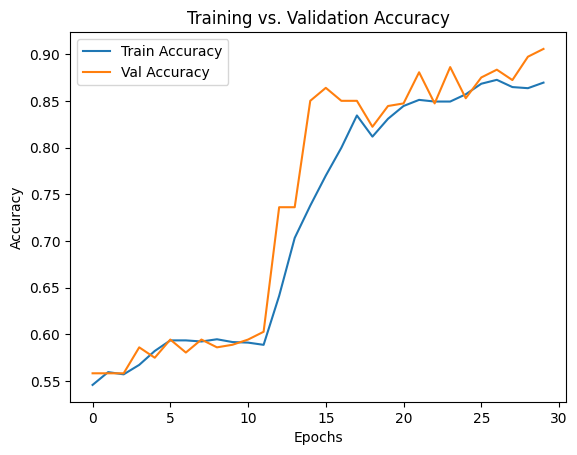

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8945 - loss: 0.2537
Test Accuracy: 0.8972, Test Loss: 0.2489


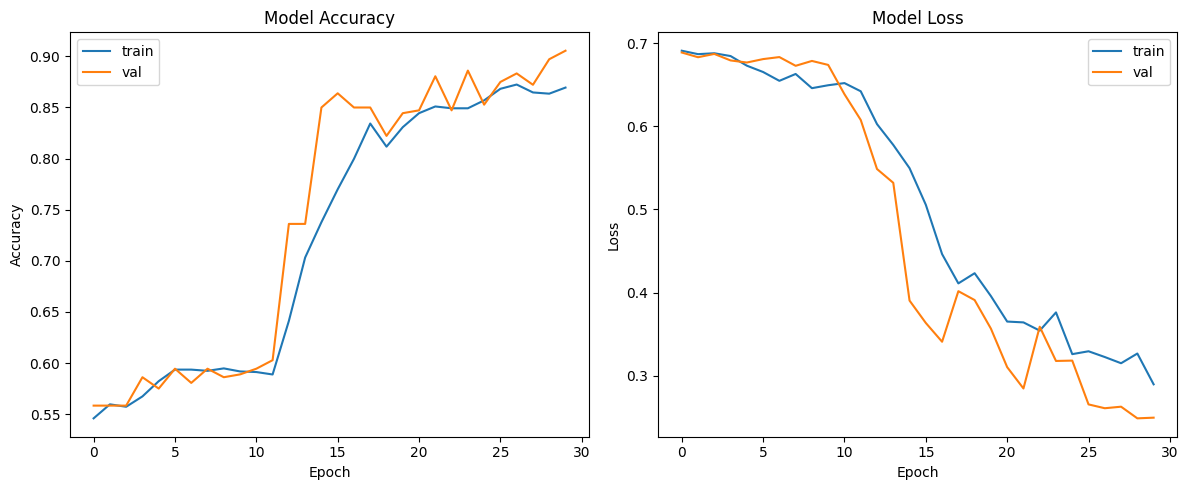

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='val')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='val')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


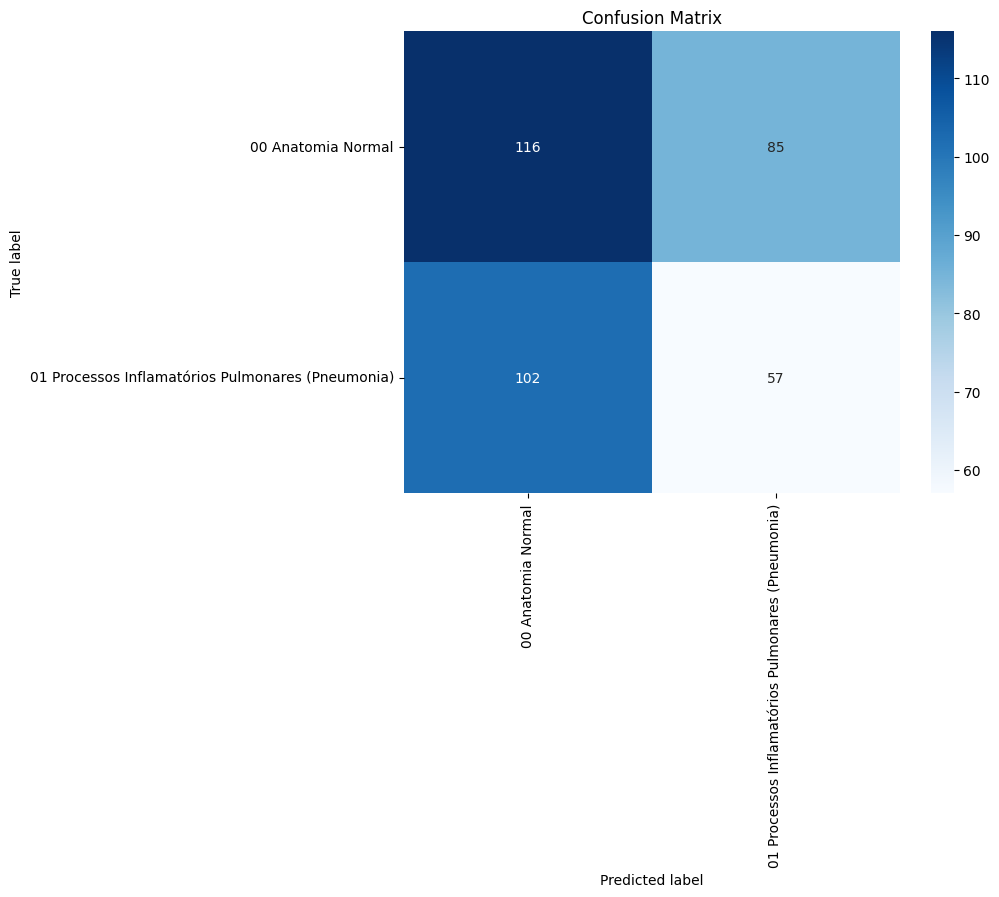

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_generator.classes

y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=True,
            xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/my_trained_model.h5')

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    accuracy = (TP + TN) / (TP + TN + FP + FN) * 100
    return TP, TN, FP, FN, accuracy


results = []


selected_classes = [
    '00 Anatomia Normal',
    '01 Processos Inflamatórios Pulmonares (Pneumonia)'
]


resolutions = [(120, 120), (150, 150), (180, 180), (224, 224)]
for resolution in resolutions:
    img_size = resolution



    y_true_train = train_generator.classes
    y_pred_train = model.predict(train_generator)
    y_pred_train = np.round(y_pred_train).astype(int)


    TP_train, TN_train, FP_train, FN_train, acc_train = calculate_metrics(y_true_train, y_pred_train)

    y_true_test = test_generator.classes
    y_pred_test = model.predict(test_generator)
    y_pred_test = np.round(y_pred_test).astype(int)

    TP_test, TN_test, FP_test, FN_test, acc_test = calculate_metrics(y_true_test, y_pred_test)

    results.append([ img_size[0], img_size[1], len(train_generator.classes), TP_train, TN_train, FP_train, FN_train, acc_train])
    results.append([ img_size[0], img_size[1], len(test_generator.classes), TP_test, TN_test, FP_test, FN_test, acc_test])

columns = ['Train data', 'Resolution', 'Data size', 'TP', 'TN', 'FP', 'FN', 'Acc (%)']

df = pd.DataFrame(results, columns=columns)

print(df)


53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
   Train data  Resolution  Data size   TP   TN   FP   FN    Acc (%)
0         120         120       1678  327  546  391  414  52.026222
1         120         120        360   66  125   76   93  53.055556
2         150         150       1678  304  542  395  437  50.417163
3         150         150        360   61  120   81   98  50.277778
4         180         180       1678  311  537  400  430  50.536353
5         180         180        360   64  123   78   95  51.944444
6         224         224       1678  326  548  389  415  52.085816
7         224         224        360   63  122   79   96  51.388889


In [ ]:
results.append([1, img_size[0], img_size[1], len(train_generator.classes), TP_train, TN_train, FP_train, FN_train, acc_train])
results.append([0, img_size[0], img_size[1], len(test_generator.classes), TP_test, TN_test, FP_test, FN_test, acc_test])


In [ ]:
columns = ['S.No', 'Model', 'Train data', 'Resolution', 'Data size', 'TP', 'TN', 'FP', 'FN', 'Acc (%)']


# LIME

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np


explainer = lime_image.LimeImageExplainer()

def model_predict(images):
    if images.ndim == 4 and images.shape[-1] == 3:
        images = images.mean(axis=-1, keepdims=True)
    elif images.ndim == 3:
        images = np.expand_dims(images, -1)

    if images.shape[-1] != 1:
        images = np.expand_dims(images, -1)

    return model.predict(images)

In [ ]:
def get_examples_per_digit(x_test, y_test):
    examples = {}
    for i in range(len(x_test)):
        true_label = np.argmax(y_test[i])
        if true_label not in examples:
            examples[true_label] = x_test[i]
        if len(examples) == 10:
            break
    return examples

x_test, y_test = next(test_generator)

digit_examples = get_examples_per_digit(x_test, y_test)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

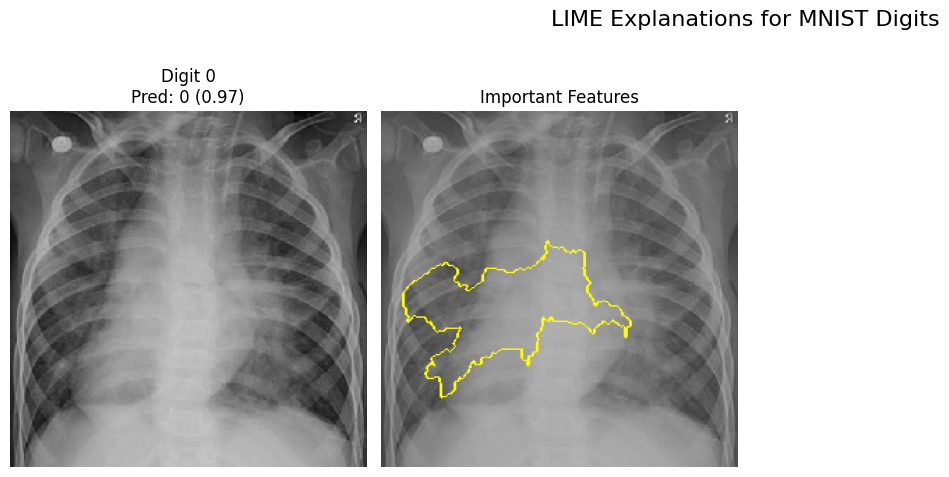

In [ ]:
plt.figure(figsize=(15, 20))

for digit in sorted(digit_examples.keys()):
    image = digit_examples[digit]

    explanation = explainer.explain_instance(
        image.squeeze(),
        model_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    pred = model.predict(image[np.newaxis, ...])
    pred_class = np.argmax(pred)
    pred_prob = np.max(pred)

    temp, mask = explanation.get_image_and_mask(
        pred_class,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    plt.subplot(5, 4, digit*2 + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Digit {digit}\nPred: {pred_class} ({pred_prob:.2f})')
    plt.axis('off')

    plt.subplot(5, 4, digit*2 + 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('Important Features')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('LIME Explanations for MNIST Digits', y=1.02, fontsize=16)
plt.show()

# **SHAP**

In [ ]:
digit_indices = {digit: None for digit in range(10)}
for i in range(len(x_test)):
    true_label = np.argmax(y_test[i])
    if digit_indices[true_label] is None:
        digit_indices[true_label] = i
    if all(v is not None for v in digit_indices.values()):
        break

In [ ]:
import shap
import numpy as np

x_train, y_train = next(train_generator)
for _ in range(len(train_generator) - 1):
    x_batch, y_batch = next(train_generator)
    x_train = np.concatenate([x_train, x_batch])
    y_train = np.concatenate([y_train, y_batch])
num_background_samples = 25
background_indices = np.random.choice(x_train.shape[0], num_background_samples, replace=False)
background = x_train[background_indices]
test_images = np.array([digit_examples[i] for i in range(len(digit_examples))])
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_images)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(25, 256, 256, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 256, 256, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 256, 256, 1))'

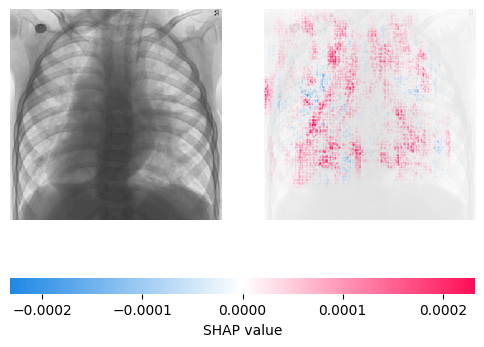

In [ ]:
shap.image_plot(shap_values, -test_images)

# Second Model

In [1]:
def build_model2(input_shape=(224, 224, 3), num_classes=2):
    base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    base_model.trainable = False

    head = base_model.output
    head = AveragePooling2D(pool_size=(4, 4))(head)
    head = Flatten()(head)
    head = Dense(64, activation='relu')(head)
    head = Dropout(0.5)(head)
    head = Dense(num_classes, activation='softmax')(head)

    model = Model(inputs=base_model.input, outputs=head)
    return model
